# Part 2 Visualisation of result, MSE with different angle range

## Environment building

In [1]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image, ImageFilter
import random

# tensorflow
import tensorflow as tf
import keras
from tensorflow.keras.models import load_model


import cv2
from imgaug import augmenters as img_aug


# Image Visualisation


In [2]:
model_output_dir = '../angle_prediction/new'

In [3]:
df_ci=pd.read_csv('../angle_prediction/csv_data/test/df_ci_v2.csv')
df_cb=pd.read_csv('../angle_prediction/csv_data/test/df_cb_v2.csv')
df_li=pd.read_csv('../angle_prediction/csv_data/test/df_li_v2.csv')
df_lb=pd.read_csv('../angle_prediction/csv_data/test/df_lb_v2.csv')
df_o =pd.read_csv('../angle_prediction/csv_data/test/df_o_v2.csv')
df_try = pd.read_csv('../angle_prediction/csv_data/df_try.csv')

In [6]:
#wtih gpu
def my_imread(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def img_preprocess(image):

    height, _, _ = image.shape
    image = image[int(height/2):,:,:]  # remove top 0.5 of the image, as it is not relavant for lane following
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)  # Nvidia model said it is best to use YUV color space
    image = cv2.GaussianBlur(image, (3,3), 0)
    image = cv2.resize(image, (200,66)) # input image size (200,66) Nvidia model
    image = image / 255 # normalizing, the processed image becomes black for some reason.  do we need this?
    return image

In [7]:
def image_gen_vis_v2(image_paths, steering_angles, batch_size,rand):
    while True:
        batch_images = []
        batch_steering_angles = []
        batch_path = []
        
        for i in range(batch_size):
            if isinstance(rand, str):
                random_index = random.randint(0, len(image_paths) - 1)
            else:
                random_index = rand
            image_path = image_paths[random_index]
            image = my_imread(image_paths[random_index])
            steering_angle = steering_angles[random_index]
             
            image = img_preprocess(image)
            batch_images.append(image)
            batch_steering_angles.append(steering_angle)
            batch_path.append(image_paths[random_index])
            
        yield( np.asarray(batch_images), np.asarray(batch_steering_angles),batch_path)
            
            

In [8]:
df_ci['Imagepath'][0]

'../ccnn_output_sullychen/instance_image/0.jpg'

In [8]:
def get_mask_path(lo_angle,up_angle,idx):
    #idx: the index of image i.e. the ith image, likely 0
    idx=int(idx)
    df_test_ci = df_ci[df_ci['Angle']>=lo_angle][df_ci['Angle']<=up_angle].reset_index()
    df_test_cb = df_cb[df_ci['Angle']>=lo_angle][df_cb['Angle']<=up_angle].reset_index()
    df_test_li = df_li[df_li['Angle']>=lo_angle][df_li['Angle']<=up_angle].reset_index()
    df_test_lb = df_lb[df_lb['Angle']>=lo_angle][df_lb['Angle']<=up_angle].reset_index()
    df_test_o = df_o[df_o['Angle']>=lo_angle][df_o['Angle']<=up_angle].reset_index()
    if idx==0:
        testx_ci,testx_cb,testx_li,testx_lb,testx_o = df_test_ci['Imagepath'][idx],df_test_cb['Imagepath'][idx],df_test_li['Imagepath'][idx],df_test_lb['Imagepath'][idx]
        testy_ci,testy_cb,testy_li,testy_lb,testy_o = df_test_ci['Angle'][idx],df_test_cb['Angle'][idx],df_test_li['Angle'][idx],df_test_lb['Angle'][idx]

    else:
        testx_ci,testx_cb,testx_li,testx_lb,testx_o = list(df_test_ci['Imagepath'])[idx],list(df_test_cb['Imagepath'])[idx],list(df_test_li['Imagepath'])[idx],list(df_test_lb['Imagepath'])[idx]
        testy_ci,testy_cb,testy_li,testy_lb,testy_o = list(df_test_ci['Angle'])[idx],list(df_test_cb['Angle'])[idx],list(df_test_li['Angle'])[idx],list(df_test_lb['Angle'])[idx]
    return testx_ci,testx_cb,testx_li,testx_lb,testx_o, testy_ci,testy_cb,testy_li,testy_lb,testy_o

In [9]:
def get_path_list(lo_angle,up_angle):
    df_test_ci = df_ci[df_ci['Angle']>=lo_angle][df_ci['Angle']<=up_angle].reset_index()
    df_test_cb = df_cb[df_ci['Angle']>=lo_angle][df_cb['Angle']<=up_angle].reset_index()
    df_test_li = df_li[df_li['Angle']>=lo_angle][df_li['Angle']<=up_angle].reset_index()
    df_test_lb = df_lb[df_lb['Angle']>=lo_angle][df_lb['Angle']<=up_angle].reset_index()
    df_test_o = df_o[df_o['Angle']>=lo_angle][df_o['Angle']<=up_angle].reset_index()
    df_test_try = df_try[df_try['Angle']>=lo_angle][df_try['Angle']<=up_angle].reset_index()
    testx_ci,testx_cb,testx_li,testx_lb,testx_o,testx_try = list(df_test_ci['Imagepath']),list(df_test_cb['Imagepath']),list(df_test_li['Imagepath']),list(df_test_lb['Imagepath']),list(df_test_o['Imagepath']),list(df_test_try['Imagepath'])
    testy_ci,testy_cb,testy_li,testy_lb,testy_o,testy_try = list(df_test_ci['Angle']),list(df_test_cb['Angle']),list(df_test_li['Angle']),list(df_test_lb['Angle']),list(df_test_o['Angle']),list(df_test_try['Angle'])
    return testx_ci,testx_cb,testx_li,testx_lb,testx_o, testy_ci,testy_cb,testy_li,testy_lb,testy_o

In [10]:
def get_path_list_try(lo_angle,up_angle):
    df_test_ci = df_ci[df_ci['Angle']>=lo_angle][df_ci['Angle']<=up_angle].reset_index()
    df_test_cb = df_cb[df_ci['Angle']>=lo_angle][df_cb['Angle']<=up_angle].reset_index()
    df_test_li = df_li[df_li['Angle']>=lo_angle][df_li['Angle']<=up_angle].reset_index()
    df_test_lb = df_lb[df_lb['Angle']>=lo_angle][df_lb['Angle']<=up_angle].reset_index()
    df_test_o = df_o[df_o['Angle']>=lo_angle][df_o['Angle']<=up_angle].reset_index()
    df_test_try = df_try[df_try['Angle']>=lo_angle][df_try['Angle']<=up_angle].reset_index()
    testx_ci,testx_cb,testx_li,testx_lb,testx_o,testx_try = list(df_test_ci['Imagepath']),list(df_test_cb['Imagepath']),list(df_test_li['Imagepath']),list(df_test_lb['Imagepath']),list(df_test_o['Imagepath']),list(df_test_try['Imagepath'])
    testy_ci,testy_cb,testy_li,testy_lb,testy_o,testy_try = list(df_test_ci['Angle']),list(df_test_cb['Angle']),list(df_test_li['Angle']),list(df_test_lb['Angle']),list(df_test_o['Angle']),list(df_test_try['Angle'])
    return testx_ci,testx_cb,testx_li,testx_lb,testx_o,testx_try, testy_ci,testy_cb,testy_li,testy_lb,testy_o ,testy_try

In [12]:
from sklearn.metrics import mean_squared_error, r2_score

def summarize(Y_true, Y_pred):
    mse = mean_squared_error(Y_true, Y_pred)
    print(f'mse = {mse:.2}')


def predict_analysis(X, Y, method):
    model = load_model(f'{model_output_dir}/lane_navigation_final_'+method+'.h5')
    Y_pred = model.predict(X)
    summarize(Y, Y_pred)
    return Y_pred

def predict_analysis_v2(X, Y, method):
    model = load_model(f'{model_output_dir}/lane_navigation_final_'+method+'.h5')
    Y_pred_ = model.predict(X)
    Y_pred = []
    diffdict = {}

    for i in range(len(Y_pred_)):
        Y_pred.append(float(Y_pred_[i][0]))
        
    for i in range(len(Y)):
        diffdict.update({str(i): abs(Y[i]-Y_pred[i])})
    maxid = int(list(diffdict.keys())[list(diffdict.values()).index(max(diffdict.values()))])
    summarize(Y, Y_pred)
    
    return Y_pred, maxid

# photo finding

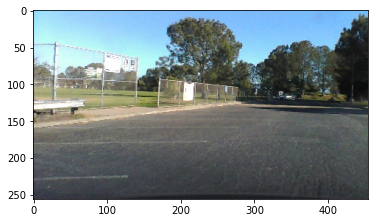

In [18]:
idimg = 23404
plt.imshow(my_imread('../SullyChen/data/'+str(idimg)+'.jpg'))

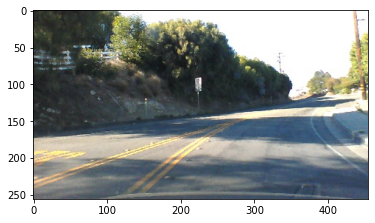

In [17]:
idimg = 36012
plt.imshow(my_imread('../SullyChen/data/'+str(idimg)+'.jpg'))

## Visualisation on different angle

## normal + normal lane segmentation

/tmp/.tyh002/ipykernel_9660/2683138522.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_ci = df_ci[df_ci['Angle']>=lo_angle][df_ci['Angle']<=up_angle].reset_index()
/tmp/.tyh002/ipykernel_9660/2683138522.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_cb = df_cb[df_ci['Angle']>=lo_angle][df_cb['Angle']<=up_angle].reset_index()
/tmp/.tyh002/ipykernel_9660/2683138522.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_li = df_li[df_li['Angle']>=lo_angle][df_li['Angle']<=up_angle].reset_index()
/tmp/.tyh002/ipykernel_9660/2683138522.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_lb = df_lb[df_lb['Angle']>=lo_angle][df_lb['Angle']<=up_angle].reset_index()
/tmp/.tyh002/ipykernel_9660/2683138522.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_o = df_o[df_o['Angle']>=lo_angle][df_

mse = 2e+01
mse = 9.1e+01
mse = 4e+01
mse = 9.5e+01
mse = 3.6e+01


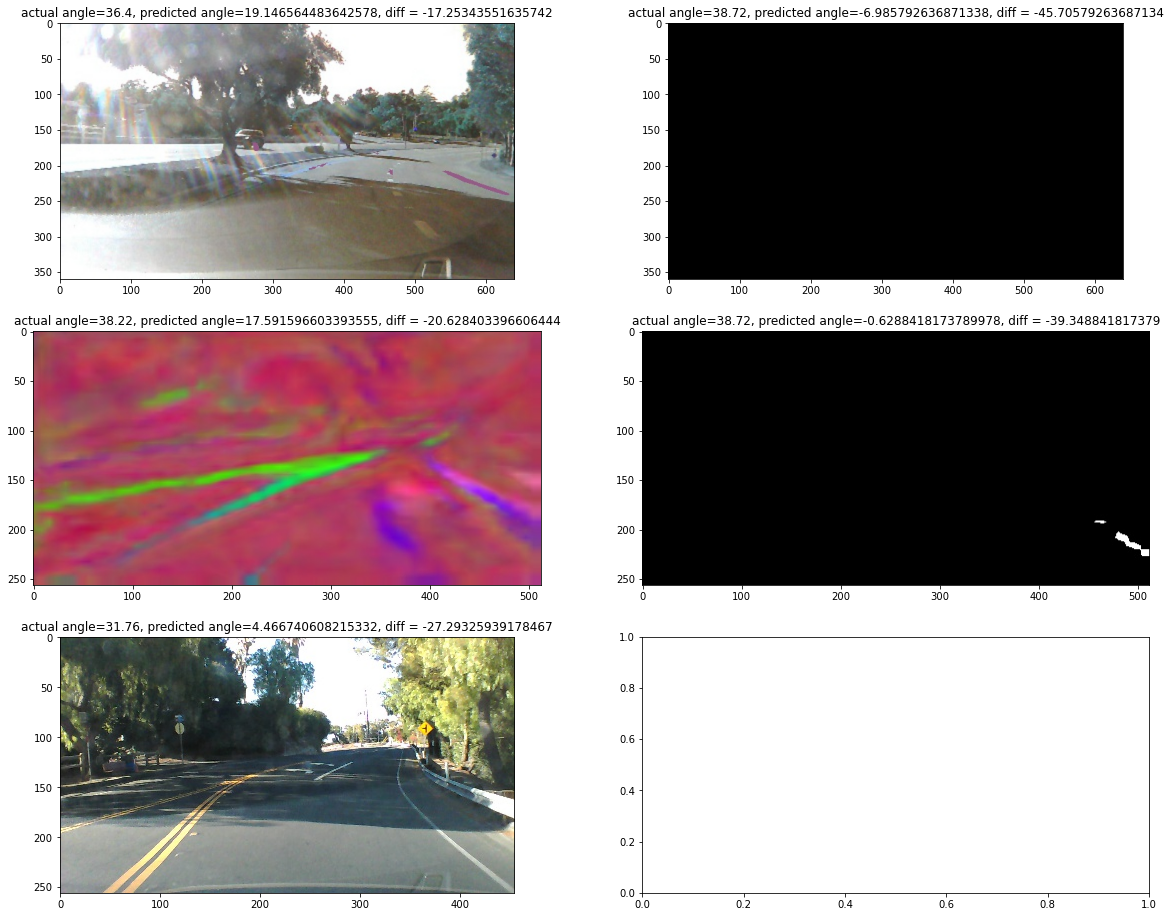

In [92]:
lo_angle = 30
up_angle = 40
idx = 'random'
testx_ci,testx_cb,testx_li,testx_lb,testx_o, testy_ci,testy_cb,testy_li,testy_lb,testy_o = get_path_list(lo_angle,up_angle)

fig, axes = plt.subplots(3, 2, figsize=(20,16))
 

i=0
x,y,z,m=0,0,0,'ci'
for testx,testy in zip([testx_ci,testx_cb,testx_li,testx_lb,testx_o],[testy_ci,testy_cb,testy_li,testy_lb,testy_o]):  
    
    if i==1:
        x,y,m=0,1,'cb'
    elif i==2:
        x,y,m=1,0,'li'
    elif i==3:
        x,y,m=1,1,'lb'
    elif i==4:
        x,y,m=1,1,'o'

    X_test, y_test,pathx = next(image_gen_vis_v2(testx,testy, 100,idx))
    #last digit if wanna point to id, input int, if want random, input 'random'
    y_pred,ind = predict_analysis_v2(X_test, y_test,m)
    axes[i//2][i%2].imshow(my_imread(pathx[ind]))
    axes[i//2][i%2].set_title(f"actual angle={y_test[ind]}, predicted angle={float(y_pred[ind])}, diff = {float(y_pred[ind])-y_test[ind]}")
    i+=1


/tmp/.tyh002/ipykernel_21404/2122698679.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_ci = df_ci[df_ci['Angle']>=lo_angle][df_ci['Angle']<=up_angle].reset_index()
/tmp/.tyh002/ipykernel_21404/2122698679.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_cb = df_cb[df_ci['Angle']>=lo_angle][df_cb['Angle']<=up_angle].reset_index()
/tmp/.tyh002/ipykernel_21404/2122698679.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_li = df_li[df_li['Angle']>=lo_angle][df_li['Angle']<=up_angle].reset_index()
/tmp/.tyh002/ipykernel_21404/2122698679.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_lb = df_lb[df_lb['Angle']>=lo_angle][df_lb['Angle']<=up_angle].reset_index()
/tmp/.tyh002/ipykernel_21404/2122698679.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_o = df_o[df_o['Angle']>=lo_angle

mse = 3e+01
mse = 2.3e+01
mse = 2.9e+01
mse = 1.7e+01
mse = 2e+01


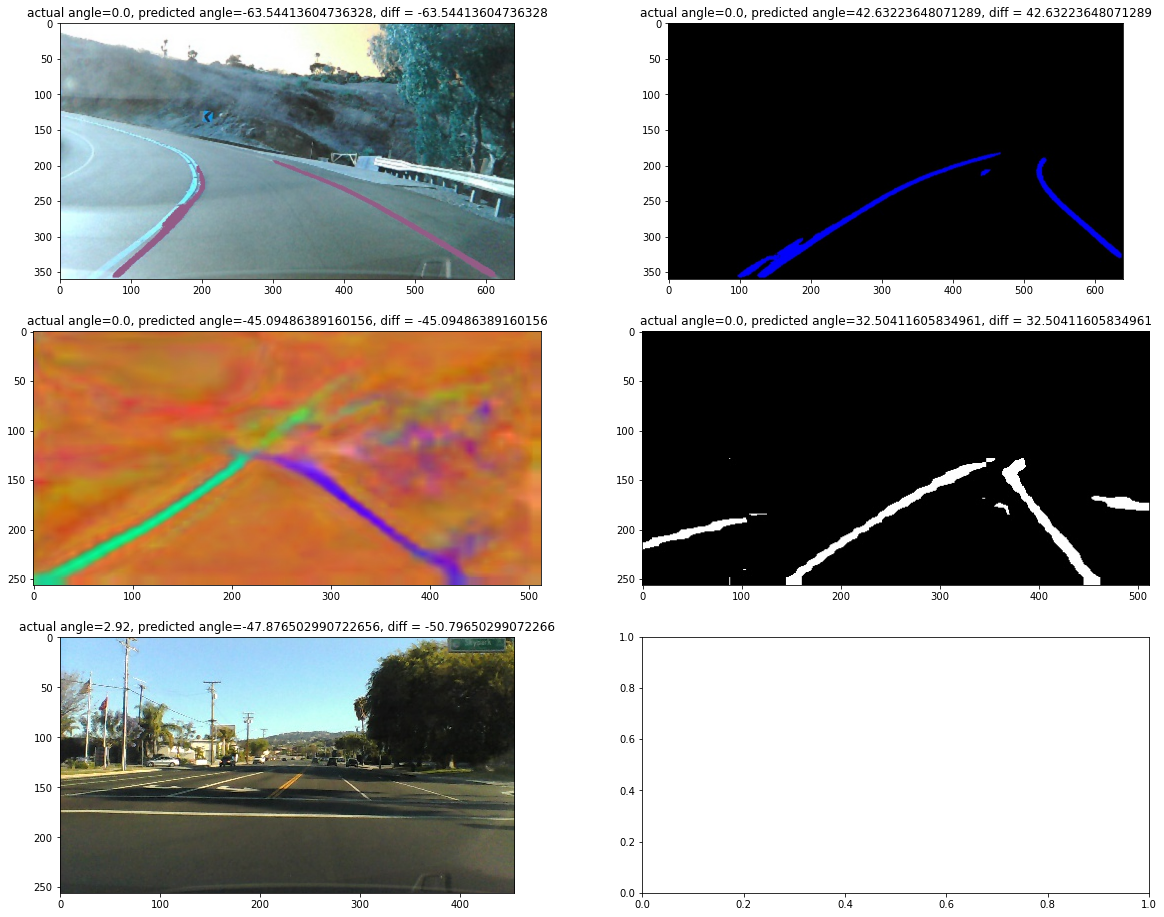

In [10]:
lo_angle = -5
up_angle = 5
idx = 'random'
testx_ci,testx_cb,testx_li,testx_lb,testx_o, testy_ci,testy_cb,testy_li,testy_lb,testy_o = get_path_list(lo_angle,up_angle)

fig, axes = plt.subplots(3, 2, figsize=(20,16))
 

i=0
x,y,z,m=0,0,0,'ci'
for testx,testy in zip([testx_ci,testx_cb,testx_li,testx_lb,testx_o],[testy_ci,testy_cb,testy_li,testy_lb,testy_o]):  
    
    if i==1:
        x,y,m=0,1,'cb'
    elif i==2:
        x,y,m=1,0,'li'
    elif i==3:
        x,y,m=1,1,'lb'
    elif i==4:
        x,y,m=1,1,'o'

    X_test, y_test,pathx = next(image_gen_vis_v2(testx,testy, 256,idx))
    #last digit if wanna point to id, input int, if want random, input 'random'
    y_pred,ind = predict_analysis_v2(X_test, y_test,m)
    axes[i//2][i%2].imshow(my_imread(pathx[ind]))
    axes[i//2][i%2].set_title(f"actual angle={y_test[ind]}, predicted angle={float(y_pred[ind])}, diff = {float(y_pred[ind])-y_test[ind]}")
    i+=1


/tmp/.tyh002/ipykernel_24610/2122698679.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_ci = df_ci[df_ci['Angle']>=lo_angle][df_ci['Angle']<=up_angle].reset_index()
/tmp/.tyh002/ipykernel_24610/2122698679.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_cb = df_cb[df_ci['Angle']>=lo_angle][df_cb['Angle']<=up_angle].reset_index()
/tmp/.tyh002/ipykernel_24610/2122698679.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_li = df_li[df_li['Angle']>=lo_angle][df_li['Angle']<=up_angle].reset_index()
/tmp/.tyh002/ipykernel_24610/2122698679.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_lb = df_lb[df_lb['Angle']>=lo_angle][df_lb['Angle']<=up_angle].reset_index()
/tmp/.tyh002/ipykernel_24610/2122698679.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_o = df_o[df_o['Angle']>=lo_angle

mse = 2.1e+01
mse = 3e+01
mse = 1.9e+01
mse = 4.7e+01
mse = 1e+01


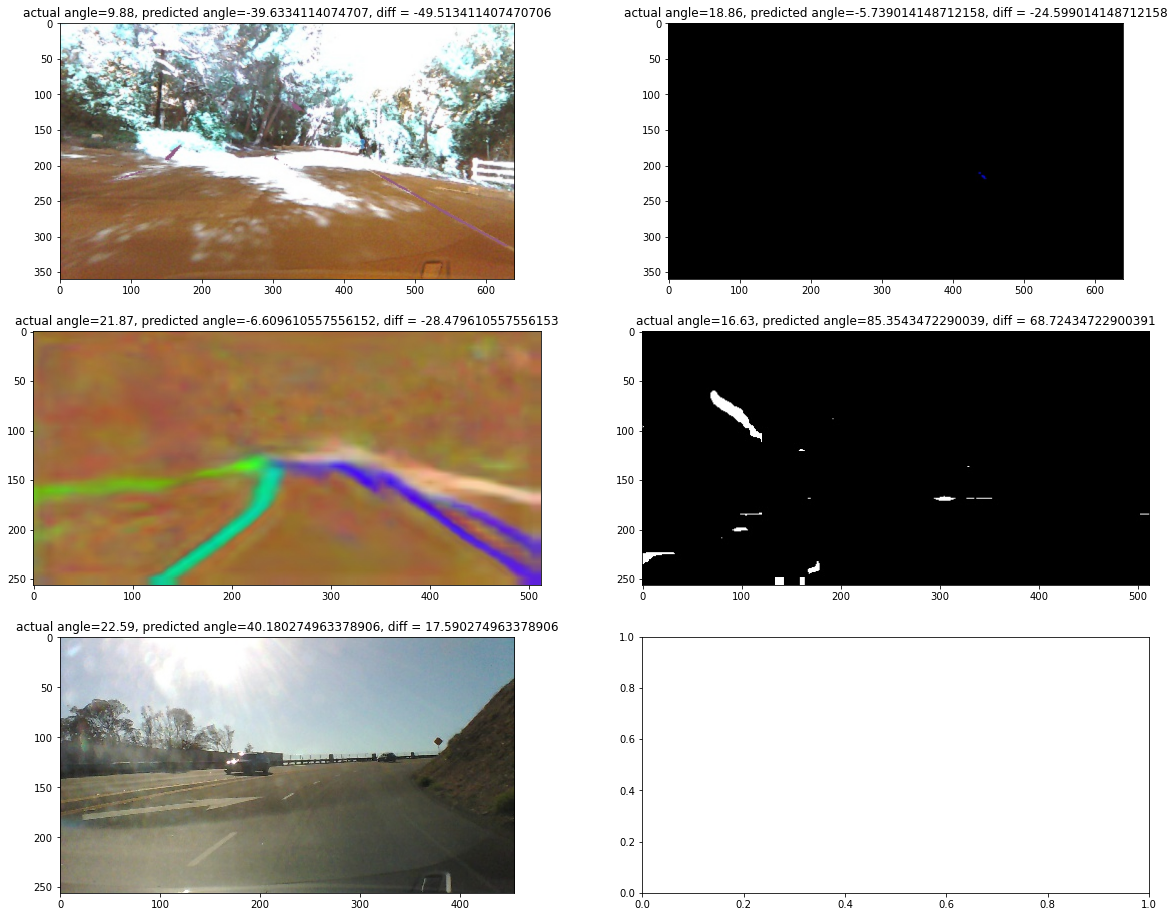

In [11]:
lo_angle = 5
up_angle = 45
idx = 'random'
testx_ci,testx_cb,testx_li,testx_lb,testx_o, testy_ci,testy_cb,testy_li,testy_lb,testy_o = get_path_list(lo_angle,up_angle)

fig, axes = plt.subplots(3, 2, figsize=(20,16))
 

i=0
x,y,z,m=0,0,0,'ci'
for testx,testy in zip([testx_ci,testx_cb,testx_li,testx_lb,testx_o],[testy_ci,testy_cb,testy_li,testy_lb,testy_o]):  
    
    if i==1:
        x,y,m=0,1,'cb'
    elif i==2:
        x,y,m=1,0,'li'
    elif i==3:
        x,y,m=1,1,'lb'
    elif i==4:
        x,y,m=1,1,'o'

    X_test, y_test,pathx = next(image_gen_vis_v2(testx,testy, 256,idx))
    #last digit if wanna point to id, input int, if want random, input 'random'
    y_pred,ind = predict_analysis_v2(X_test, y_test,m)
    axes[i//2][i%2].imshow(my_imread(pathx[ind]))
    axes[i//2][i%2].set_title(f"actual angle={y_test[ind]}, predicted angle={float(y_pred[ind])}, diff = {float(y_pred[ind])-y_test[ind]}")
    i+=1


/tmp/.tyh002/ipykernel_24610/2122698679.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_ci = df_ci[df_ci['Angle']>=lo_angle][df_ci['Angle']<=up_angle].reset_index()
/tmp/.tyh002/ipykernel_24610/2122698679.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_cb = df_cb[df_ci['Angle']>=lo_angle][df_cb['Angle']<=up_angle].reset_index()
/tmp/.tyh002/ipykernel_24610/2122698679.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_li = df_li[df_li['Angle']>=lo_angle][df_li['Angle']<=up_angle].reset_index()
/tmp/.tyh002/ipykernel_24610/2122698679.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_lb = df_lb[df_lb['Angle']>=lo_angle][df_lb['Angle']<=up_angle].reset_index()
/tmp/.tyh002/ipykernel_24610/2122698679.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_o = df_o[df_o['Angle']>=lo_angle

mse = 2.3e+01
mse = 3.6e+01
mse = 3.6e+01
mse = 4e+01
mse = 1.1e+01


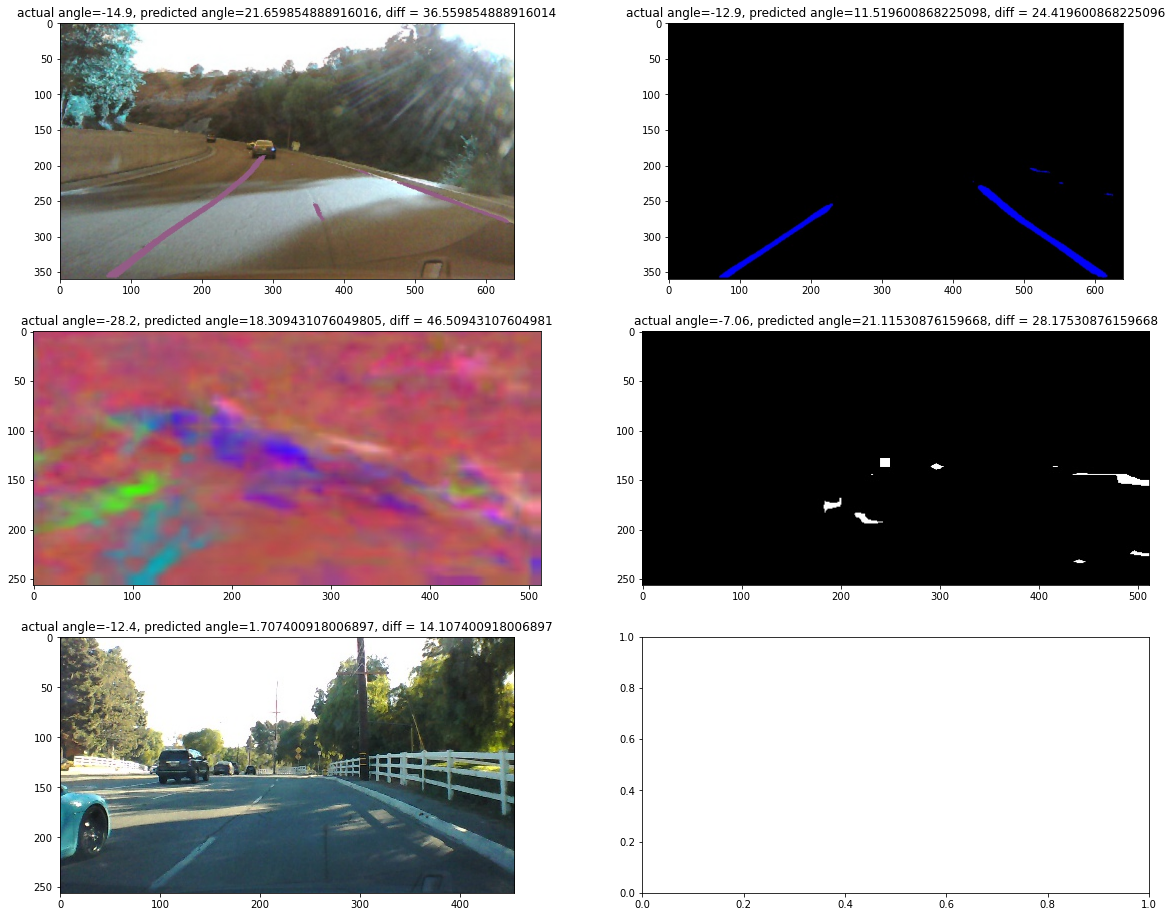

In [12]:
lo_angle = -45
up_angle = -5
idx = 'random'
testx_ci,testx_cb,testx_li,testx_lb,testx_o, testy_ci,testy_cb,testy_li,testy_lb,testy_o = get_path_list(lo_angle,up_angle)

fig, axes = plt.subplots(3, 2, figsize=(20,16))
 

i=0
x,y,z,m=0,0,0,'ci'
for testx,testy in zip([testx_ci,testx_cb,testx_li,testx_lb,testx_o],[testy_ci,testy_cb,testy_li,testy_lb,testy_o]):  
    
    if i==1:
        x,y,m=0,1,'cb'
    elif i==2:
        x,y,m=1,0,'li'
    elif i==3:
        x,y,m=1,1,'lb'
    elif i==4:
        x,y,m=1,1,'o'

    X_test, y_test,pathx = next(image_gen_vis_v2(testx,testy, 256,idx))
    #last digit if wanna point to id, input int, if want random, input 'random'
    y_pred,ind = predict_analysis_v2(X_test, y_test,m)
    axes[i//2][i%2].imshow(my_imread(pathx[ind]))
    axes[i//2][i%2].set_title(f"actual angle={y_test[ind]}, predicted angle={float(y_pred[ind])}, diff = {float(y_pred[ind])-y_test[ind]}")
    i+=1


/tmp/.tyh002/ipykernel_24610/2122698679.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_ci = df_ci[df_ci['Angle']>=lo_angle][df_ci['Angle']<=up_angle].reset_index()
/tmp/.tyh002/ipykernel_24610/2122698679.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_cb = df_cb[df_ci['Angle']>=lo_angle][df_cb['Angle']<=up_angle].reset_index()
/tmp/.tyh002/ipykernel_24610/2122698679.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_li = df_li[df_li['Angle']>=lo_angle][df_li['Angle']<=up_angle].reset_index()
/tmp/.tyh002/ipykernel_24610/2122698679.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_lb = df_lb[df_lb['Angle']>=lo_angle][df_lb['Angle']<=up_angle].reset_index()
/tmp/.tyh002/ipykernel_24610/2122698679.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_o = df_o[df_o['Angle']>=lo_angle

mse = 5.8e+01
../ccnn_output_sullychen/instance_image/25461.jpg
mse = 5.2e+02
../ccnn_output_sullychen/binary_image/23370.jpg
mse = 7.4e+01
../lanenet_output_sullychen/instance_image/36012.jpg
mse = 3e+02
../lanenet_output_sullychen/binary_image/23404.jpg
mse = 6.2e+01
../SullyChen/data/33481.jpg


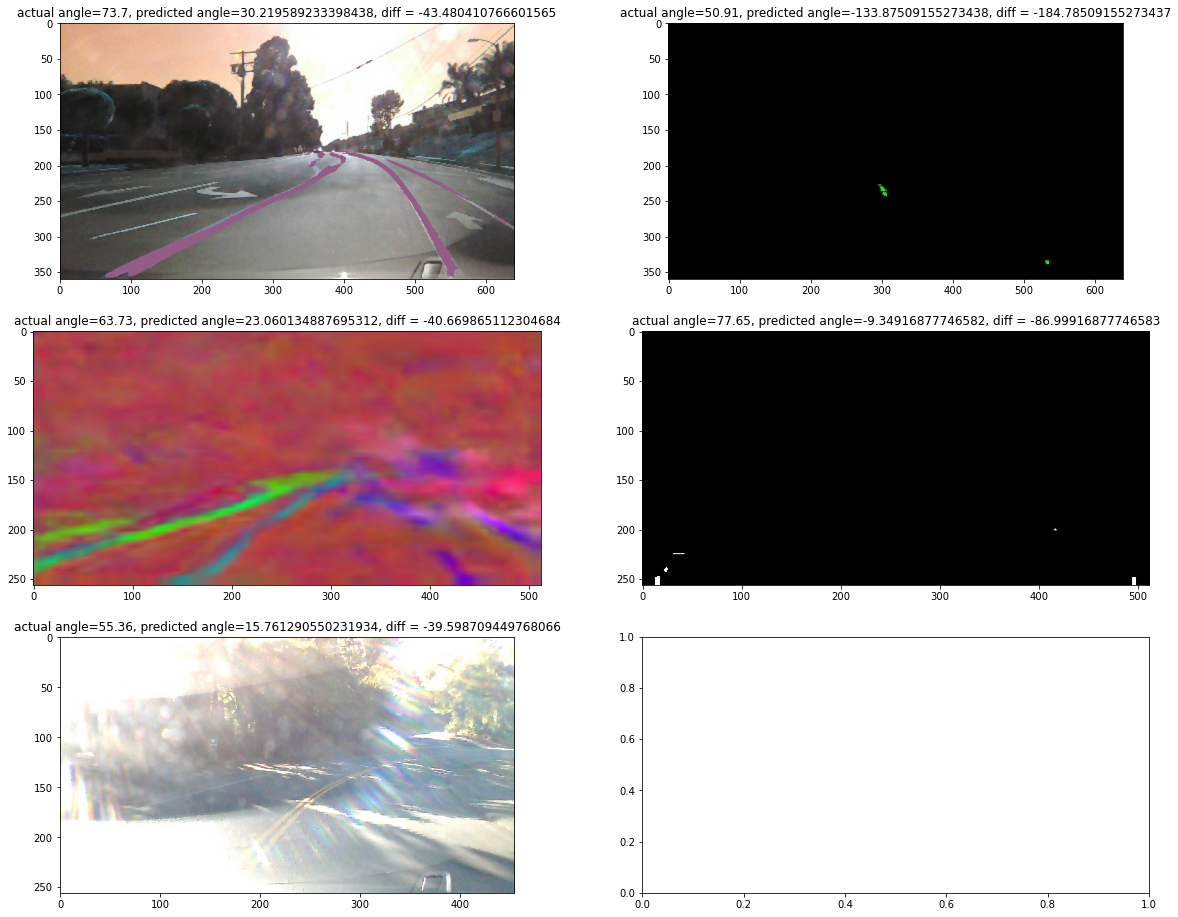

In [24]:
lo_angle = 45
up_angle = 100
idx = 'random'
testx_ci,testx_cb,testx_li,testx_lb,testx_o, testy_ci,testy_cb,testy_li,testy_lb,testy_o = get_path_list(lo_angle,up_angle)

fig, axes = plt.subplots(3, 2, figsize=(20,16))
 

i=0
x,y,z,m=0,0,0,'ci'
for testx,testy in zip([testx_ci,testx_cb,testx_li,testx_lb,testx_o],[testy_ci,testy_cb,testy_li,testy_lb,testy_o]):  
    
    if i==1:
        x,y,m=0,1,'cb'
    elif i==2:
        x,y,m=1,0,'li'
    elif i==3:
        x,y,m=1,1,'lb'
    elif i==4:
        x,y,m=1,1,'o'

    X_test, y_test,pathx = next(image_gen_vis_v2(testx,testy, 256,idx))
    #last digit if wanna point to id, input int, if want random, input 'random'
    y_pred,ind = predict_analysis_v2(X_test, y_test,m)
    axes[i//2][i%2].imshow(my_imread(pathx[ind]))
    print(pathx[ind])
    axes[i//2][i%2].set_title(f"actual angle={y_test[ind]}, predicted angle={float(y_pred[ind])}, diff = {float(y_pred[ind])-y_test[ind]}")
    i+=1


/tmp/.tyh002/ipykernel_24610/2122698679.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_ci = df_ci[df_ci['Angle']>=lo_angle][df_ci['Angle']<=up_angle].reset_index()
/tmp/.tyh002/ipykernel_24610/2122698679.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_cb = df_cb[df_ci['Angle']>=lo_angle][df_cb['Angle']<=up_angle].reset_index()
/tmp/.tyh002/ipykernel_24610/2122698679.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_li = df_li[df_li['Angle']>=lo_angle][df_li['Angle']<=up_angle].reset_index()
/tmp/.tyh002/ipykernel_24610/2122698679.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_lb = df_lb[df_lb['Angle']>=lo_angle][df_lb['Angle']<=up_angle].reset_index()
/tmp/.tyh002/ipykernel_24610/2122698679.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_o = df_o[df_o['Angle']>=lo_angle

mse = 2.8e+01
mse = 3.4e+02
mse = 9.3e+01
mse = 2.8e+02
mse = 6.7e+01


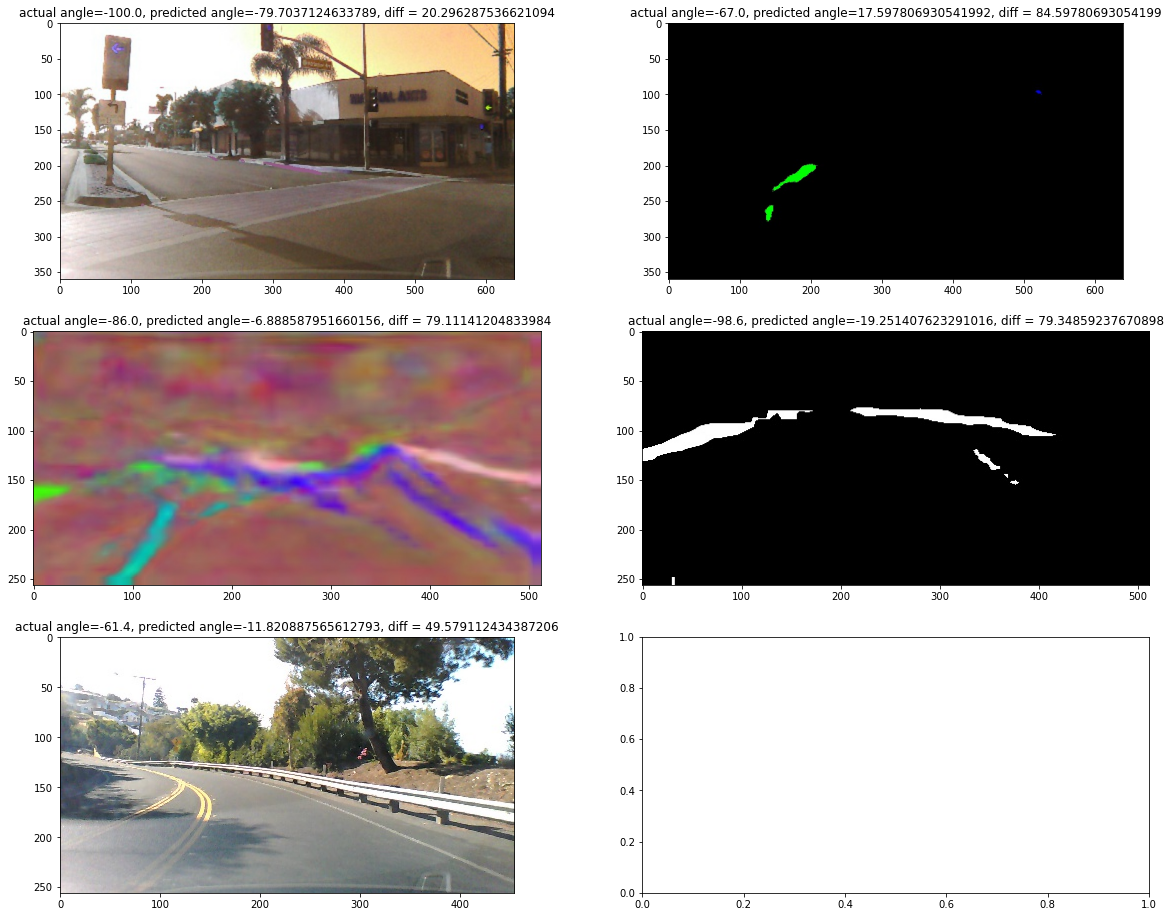

In [17]:
lo_angle = -100
up_angle = -45
idx = 'random'
testx_ci,testx_cb,testx_li,testx_lb,testx_o, testy_ci,testy_cb,testy_li,testy_lb,testy_o = get_path_list(lo_angle,up_angle)

fig, axes = plt.subplots(3, 2, figsize=(20,16))
 

i=0
x,y,z,m=0,0,0,'ci'
for testx,testy in zip([testx_ci,testx_cb,testx_li,testx_lb,testx_o],[testy_ci,testy_cb,testy_li,testy_lb,testy_o]):  
    
    if i==1:
        x,y,m=0,1,'cb'
    elif i==2:
        x,y,m=1,0,'li'
    elif i==3:
        x,y,m=1,1,'lb'
    elif i==4:
        x,y,m=1,1,'o'

    X_test, y_test,pathx = next(image_gen_vis_v2(testx,testy, 256,idx))
    #last digit if wanna point to id, input int, if want random, input 'random'
    y_pred,ind = predict_analysis_v2(X_test, y_test,m)
    axes[i//2][i%2].imshow(my_imread(pathx[ind]))
    axes[i//2][i%2].set_title(f"actual angle={y_test[ind]}, predicted angle={float(y_pred[ind])}, diff = {float(y_pred[ind])-y_test[ind]}")
    i+=1


/tmp/.tyh002/ipykernel_24610/2122698679.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_ci = df_ci[df_ci['Angle']>=lo_angle][df_ci['Angle']<=up_angle].reset_index()
/tmp/.tyh002/ipykernel_24610/2122698679.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_cb = df_cb[df_ci['Angle']>=lo_angle][df_cb['Angle']<=up_angle].reset_index()
/tmp/.tyh002/ipykernel_24610/2122698679.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_li = df_li[df_li['Angle']>=lo_angle][df_li['Angle']<=up_angle].reset_index()
/tmp/.tyh002/ipykernel_24610/2122698679.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_lb = df_lb[df_lb['Angle']>=lo_angle][df_lb['Angle']<=up_angle].reset_index()
/tmp/.tyh002/ipykernel_24610/2122698679.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_o = df_o[df_o['Angle']>=lo_angle

mse = 2.4e+02
mse = 2.5e+03
mse = 3.3e+02
mse = 1.6e+03
mse = 8e+01


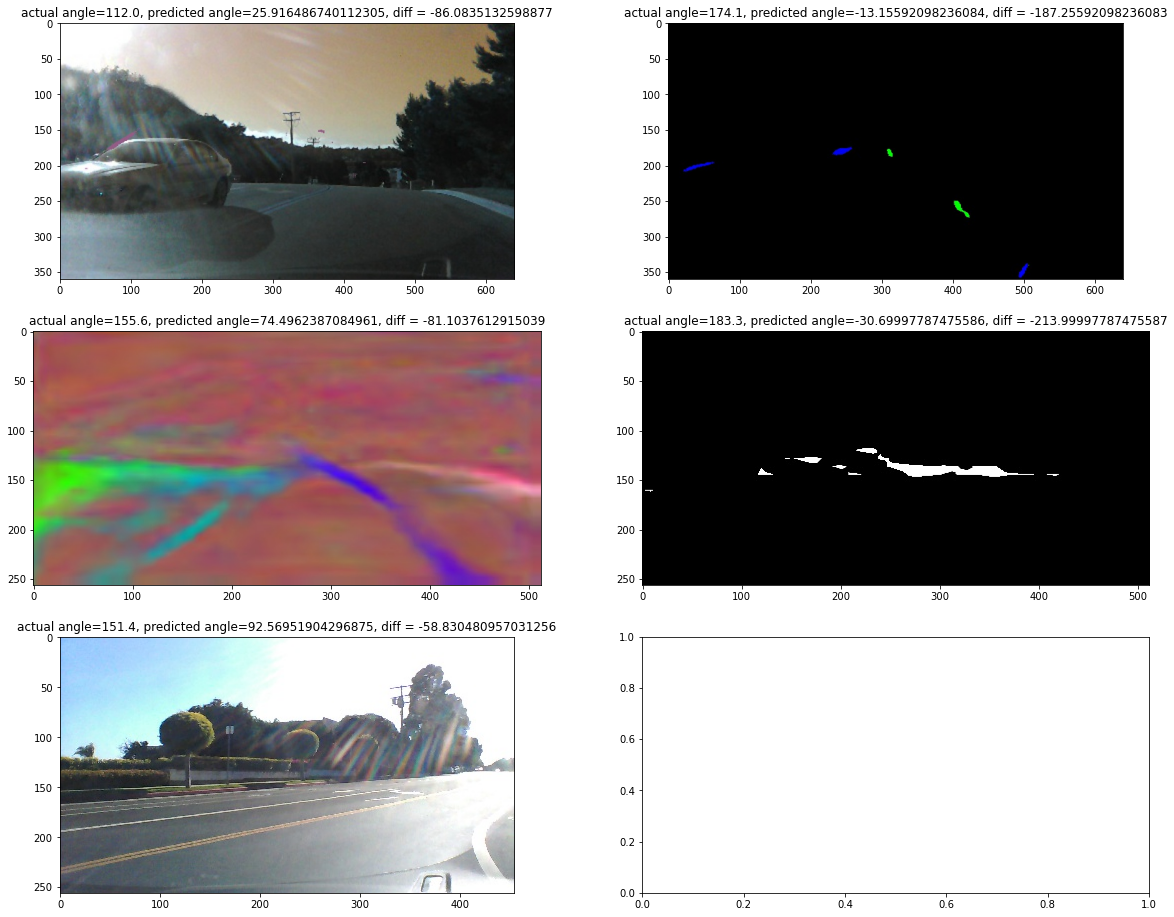

In [21]:
lo_angle = 100
up_angle = 200
idx = 'random'
testx_ci,testx_cb,testx_li,testx_lb,testx_o, testy_ci,testy_cb,testy_li,testy_lb,testy_o = get_path_list(lo_angle,up_angle)

fig, axes = plt.subplots(3, 2, figsize=(20,16))
 

i=0
x,y,z,m=0,0,0,'ci'
for testx,testy in zip([testx_ci,testx_cb,testx_li,testx_lb,testx_o],[testy_ci,testy_cb,testy_li,testy_lb,testy_o]):  
    
    if i==1:
        x,y,m=0,1,'cb'
    elif i==2:
        x,y,m=1,0,'li'
    elif i==3:
        x,y,m=1,1,'lb'
    elif i==4:
        x,y,m=1,1,'o'

    X_test, y_test,pathx = next(image_gen_vis_v2(testx,testy, 256,idx))
    #last digit if wanna point to id, input int, if want random, input 'random'
    y_pred,ind = predict_analysis_v2(X_test, y_test,m)
    axes[i//2][i%2].imshow(my_imread(pathx[ind]))
    axes[i//2][i%2].set_title(f"actual angle={y_test[ind]}, predicted angle={float(y_pred[ind])}, diff = {float(y_pred[ind])-y_test[ind]}")
    i+=1


/tmp/.tyh002/ipykernel_24610/2122698679.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_ci = df_ci[df_ci['Angle']>=lo_angle][df_ci['Angle']<=up_angle].reset_index()
/tmp/.tyh002/ipykernel_24610/2122698679.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_cb = df_cb[df_ci['Angle']>=lo_angle][df_cb['Angle']<=up_angle].reset_index()
/tmp/.tyh002/ipykernel_24610/2122698679.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_li = df_li[df_li['Angle']>=lo_angle][df_li['Angle']<=up_angle].reset_index()
/tmp/.tyh002/ipykernel_24610/2122698679.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_lb = df_lb[df_lb['Angle']>=lo_angle][df_lb['Angle']<=up_angle].reset_index()
/tmp/.tyh002/ipykernel_24610/2122698679.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_o = df_o[df_o['Angle']>=lo_angle

mse = 2.2e+02
../ccnn_output_sullychen/instance_image/21239.jpg
mse = 4.6e+03
../ccnn_output_sullychen/binary_image/50776.jpg
mse = 4.2e+02
../lanenet_output_sullychen/instance_image/24475.jpg
mse = 1.5e+03
../lanenet_output_sullychen/binary_image/23208.jpg
mse = 2.3e+02
../SullyChen/data/18267.jpg


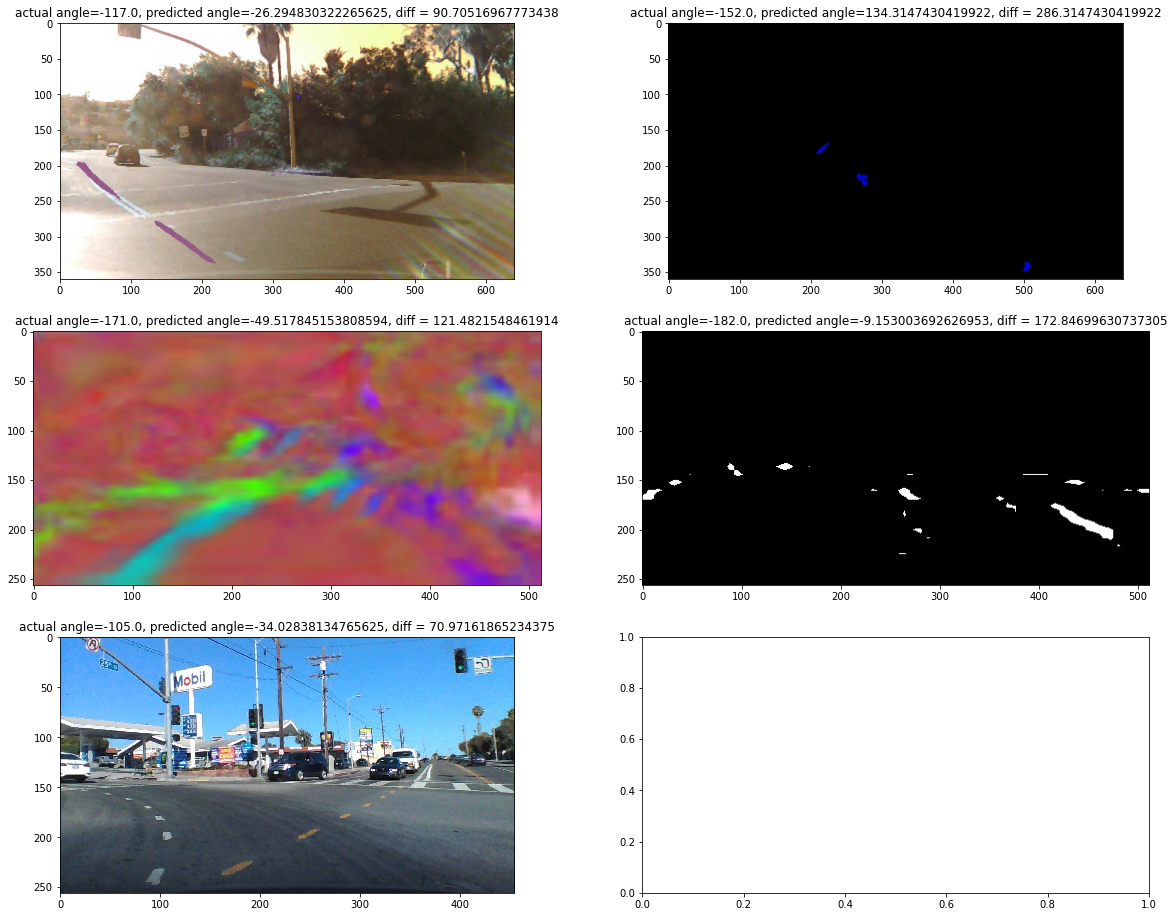

In [20]:
lo_angle = -200
up_angle = -100
idx = 'random'
testx_ci,testx_cb,testx_li,testx_lb,testx_o, testy_ci,testy_cb,testy_li,testy_lb,testy_o = get_path_list(lo_angle,up_angle)

fig, axes = plt.subplots(3, 2, figsize=(20,16))
 

i=0
x,y,z,m=0,0,0,'ci'
for testx,testy in zip([testx_ci,testx_cb,testx_li,testx_lb,testx_o],[testy_ci,testy_cb,testy_li,testy_lb,testy_o]):  
    
    if i==1:
        x,y,m=0,1,'cb'
    elif i==2:
        x,y,m=1,0,'li'
    elif i==3:
        x,y,m=1,1,'lb'
    elif i==4:
        x,y,m=1,1,'o'

    X_test, y_test,pathx = next(image_gen_vis_v2(testx,testy, 256,idx))
    #last digit if wanna point to id, input int, if want random, input 'random'
    y_pred,ind = predict_analysis_v2(X_test, y_test,m)
    print(pathx[ind])
    axes[i//2][i%2].imshow(my_imread(pathx[ind]))
    axes[i//2][i%2].set_title(f"actual angle={y_test[ind]}, predicted angle={float(y_pred[ind])}, diff = {float(y_pred[ind])-y_test[ind]}")
    i+=1


/tmp/.tyh002/ipykernel_9660/2683138522.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_ci = df_ci[df_ci['Angle']>=lo_angle][df_ci['Angle']<=up_angle].reset_index()
/tmp/.tyh002/ipykernel_9660/2683138522.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_cb = df_cb[df_ci['Angle']>=lo_angle][df_cb['Angle']<=up_angle].reset_index()
/tmp/.tyh002/ipykernel_9660/2683138522.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_li = df_li[df_li['Angle']>=lo_angle][df_li['Angle']<=up_angle].reset_index()
/tmp/.tyh002/ipykernel_9660/2683138522.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_lb = df_lb[df_lb['Angle']>=lo_angle][df_lb['Angle']<=up_angle].reset_index()
/tmp/.tyh002/ipykernel_9660/2683138522.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_o = df_o[df_o['Angle']>=lo_angle][df_

mse = 4.5e+01
mse = 1.4e+02
mse = 9.8e+01
mse = 4.3e+02
mse = 8.4e+01


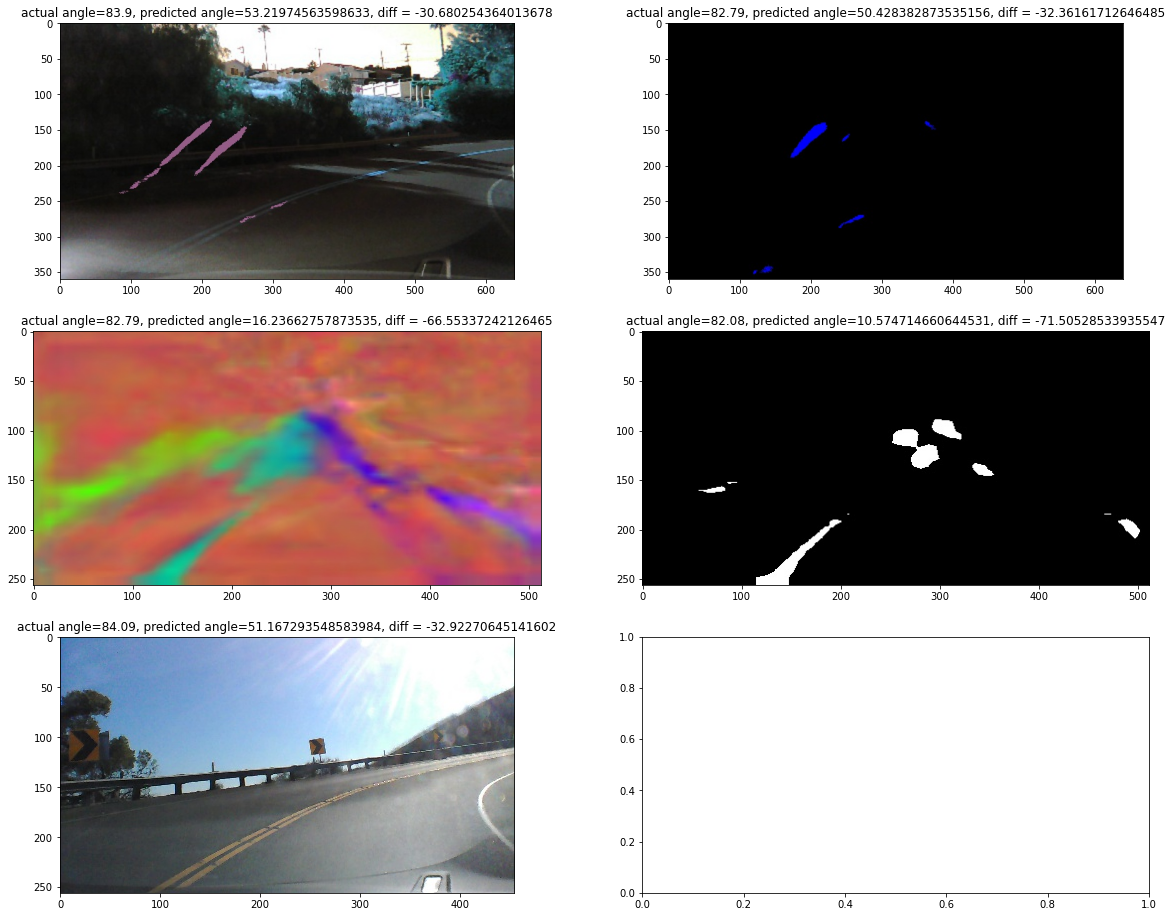

In [94]:
lo_angle = 82
up_angle = 89
idx = 'random'
testx_ci,testx_cb,testx_li,testx_lb,testx_o, testy_ci,testy_cb,testy_li,testy_lb,testy_o = get_path_list(lo_angle,up_angle)

fig, axes = plt.subplots(3, 2, figsize=(20,16))
 

i=0
x,y,z,m=0,0,0,'ci'
for testx,testy in zip([testx_ci,testx_cb,testx_li,testx_lb,testx_o],[testy_ci,testy_cb,testy_li,testy_lb,testy_o]):  
    
    if i==1:
        x,y,m=0,1,'cb'
    elif i==2:
        x,y,m=1,0,'li'
    elif i==3:
        x,y,m=1,1,'lb'
    elif i==4:
        x,y,m=1,1,'o'

    X_test, y_test,pathx = next(image_gen_vis_v2(testx,testy, 100,idx))
    #last digit if wanna point to id, input int, if want random, input 'random'
    y_pred,ind = predict_analysis_v2(X_test, y_test,m)
    axes[i//2][i%2].imshow(my_imread(pathx[ind]))
    axes[i//2][i%2].set_title(f"actual angle={y_test[ind]}, predicted angle={float(y_pred[ind])}, diff = {float(y_pred[ind])-y_test[ind]}")
    i+=1


# Extreme angle


/tmp/.tyh002/ipykernel_24610/2122698679.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_ci = df_ci[df_ci['Angle']>=lo_angle][df_ci['Angle']<=up_angle].reset_index()
/tmp/.tyh002/ipykernel_24610/2122698679.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_cb = df_cb[df_ci['Angle']>=lo_angle][df_cb['Angle']<=up_angle].reset_index()
/tmp/.tyh002/ipykernel_24610/2122698679.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_li = df_li[df_li['Angle']>=lo_angle][df_li['Angle']<=up_angle].reset_index()
/tmp/.tyh002/ipykernel_24610/2122698679.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_lb = df_lb[df_lb['Angle']>=lo_angle][df_lb['Angle']<=up_angle].reset_index()
/tmp/.tyh002/ipykernel_24610/2122698679.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_o = df_o[df_o['Angle']>=lo_angle

mse = 7.5e+01
mse = 3.8e+02
mse = 1.9e+02
mse = 2.9e+02
mse = 9.6e+01


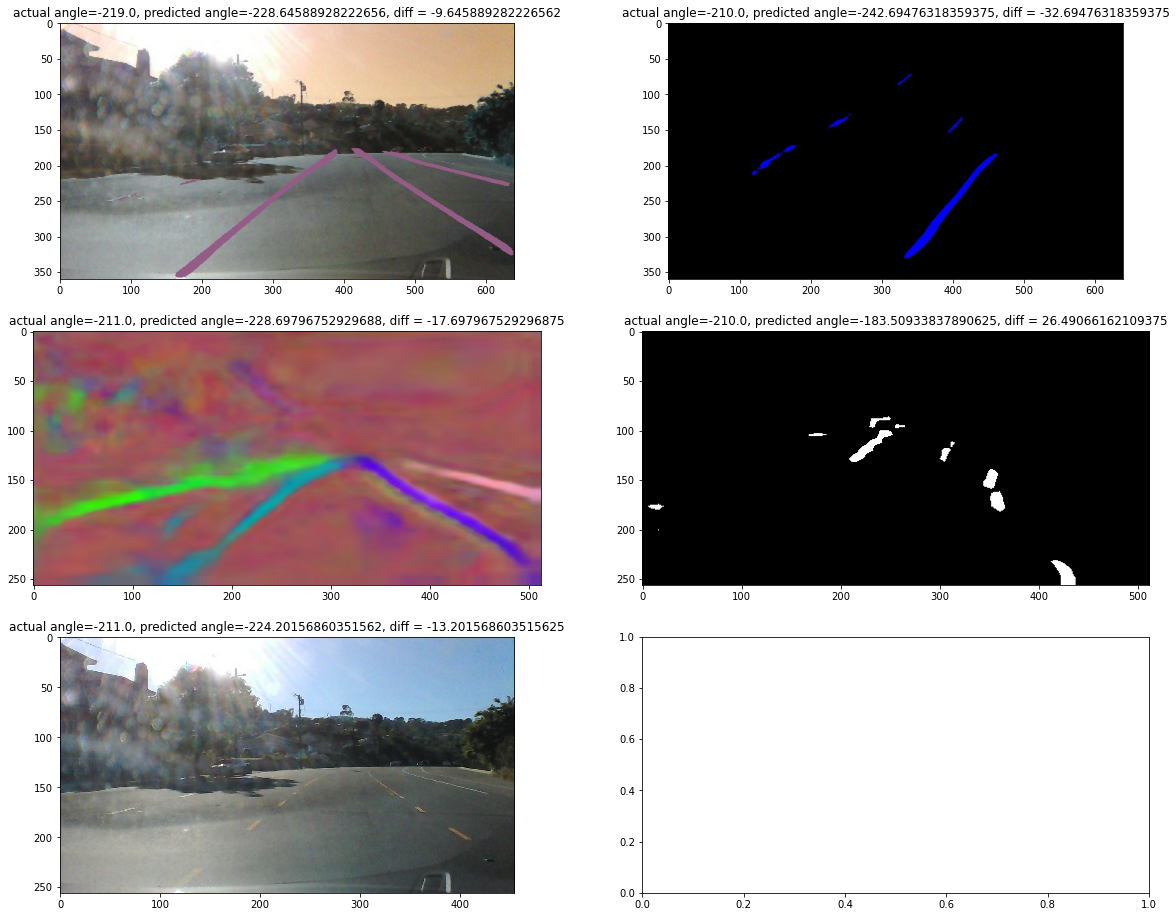

In [22]:
lo_angle = -220
up_angle = -200
idx = 'random'
testx_ci,testx_cb,testx_li,testx_lb,testx_o, testy_ci,testy_cb,testy_li,testy_lb,testy_o = get_path_list(lo_angle,up_angle)

fig, axes = plt.subplots(3, 2, figsize=(20,16))
 

i=0
x,y,z,m=0,0,0,'ci'
for testx,testy in zip([testx_ci,testx_cb,testx_li,testx_lb,testx_o],[testy_ci,testy_cb,testy_li,testy_lb,testy_o]):  
    
    if i==1:
        x,y,m=0,1,'cb'
    elif i==2:
        x,y,m=1,0,'li'
    elif i==3:
        x,y,m=1,1,'lb'
    elif i==4:
        x,y,m=1,1,'o'

    X_test, y_test,pathx = next(image_gen_vis_v2(testx,testy, 50,idx))
    #last digit if wanna point to id, input int, if want random, input 'random'
    y_pred,ind = predict_analysis_v2(X_test, y_test,m)
    axes[i//2][i%2].imshow(my_imread(pathx[ind]))
    axes[i//2][i%2].set_title(f"actual angle={y_test[ind]}, predicted angle={float(y_pred[ind])}, diff = {float(y_pred[ind])-y_test[ind]}")
    i+=1


/tmp/.tyh002/ipykernel_24610/2122698679.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_ci = df_ci[df_ci['Angle']>=lo_angle][df_ci['Angle']<=up_angle].reset_index()
/tmp/.tyh002/ipykernel_24610/2122698679.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_cb = df_cb[df_ci['Angle']>=lo_angle][df_cb['Angle']<=up_angle].reset_index()
/tmp/.tyh002/ipykernel_24610/2122698679.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_li = df_li[df_li['Angle']>=lo_angle][df_li['Angle']<=up_angle].reset_index()
/tmp/.tyh002/ipykernel_24610/2122698679.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_lb = df_lb[df_lb['Angle']>=lo_angle][df_lb['Angle']<=up_angle].reset_index()
/tmp/.tyh002/ipykernel_24610/2122698679.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test_o = df_o[df_o['Angle']>=lo_angle

mse = 1.2e+02
mse = 1.1e+04
mse = 8.5e+02
mse = 4.8e+03
mse = 9.8e+02


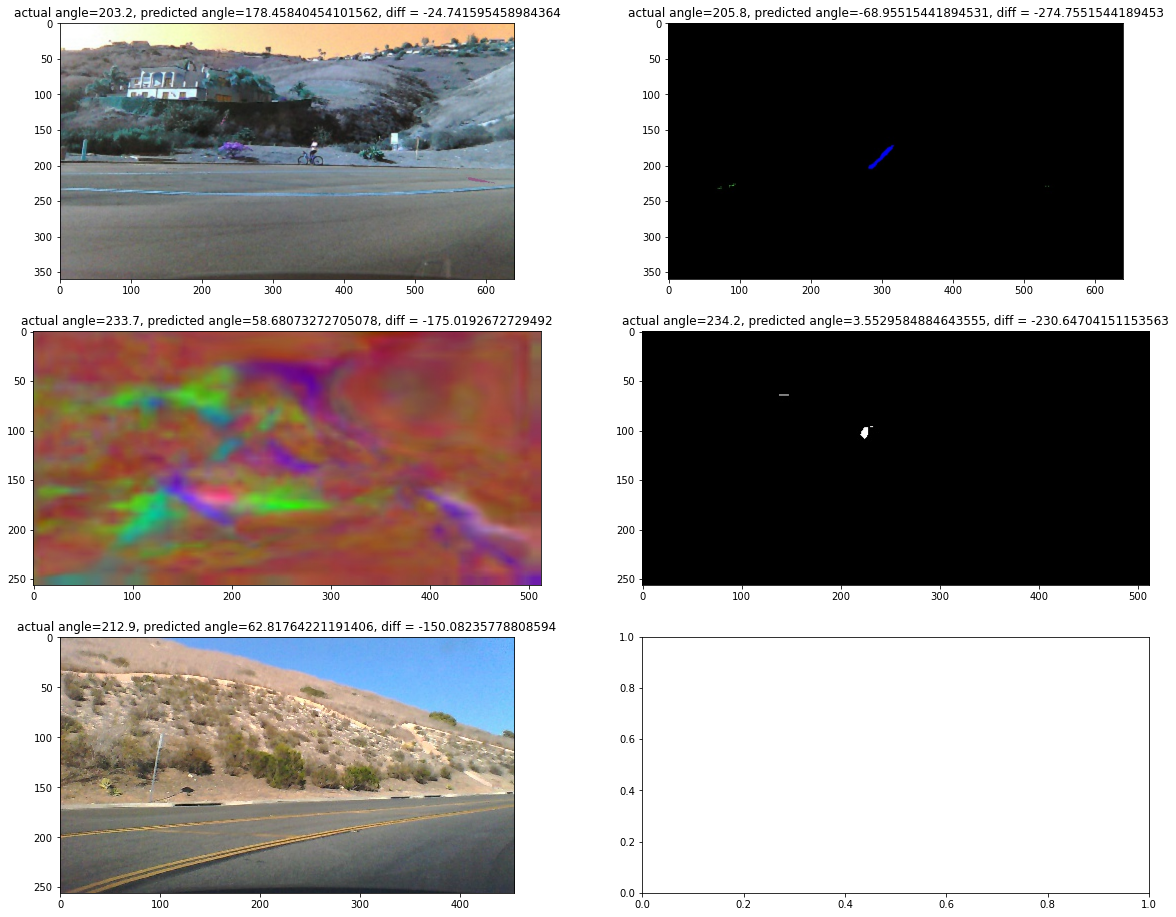

In [23]:
lo_angle = 200
up_angle = 300
idx = 'random'
testx_ci,testx_cb,testx_li,testx_lb,testx_o, testy_ci,testy_cb,testy_li,testy_lb,testy_o = get_path_list(lo_angle,up_angle)

fig, axes = plt.subplots(3, 2, figsize=(20,16))
 

i=0
x,y,z,m=0,0,0,'ci'
for testx,testy in zip([testx_ci,testx_cb,testx_li,testx_lb,testx_o],[testy_ci,testy_cb,testy_li,testy_lb,testy_o]):  
    
    if i==1:
        x,y,m=0,1,'cb'
    elif i==2:
        x,y,m=1,0,'li'
    elif i==3:
        x,y,m=1,1,'lb'
    elif i==4:
        x,y,m=1,1,'o'

    X_test, y_test,pathx = next(image_gen_vis_v2(testx,testy, 50,idx))
    #last digit if wanna point to id, input int, if want random, input 'random'
    y_pred,ind = predict_analysis_v2(X_test, y_test,m)
    axes[i//2][i%2].imshow(my_imread(pathx[ind]))
    axes[i//2][i%2].set_title(f"actual angle={y_test[ind]}, predicted angle={float(y_pred[ind])}, diff = {float(y_pred[ind])-y_test[ind]}")
    i+=1
